In [1]:
import numpy as np
import matplotlib.pylab as pl
import ot
import ot.plot
import src.sinkhorn as snk
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from tqdm import tqdm
import jax
from ot.datasets import make_1D_gauss as gauss
import warnings

In [2]:
warnings.filterwarnings("ignore")

The following function computes the cost of the transport plan that will result from the sinkhorn algorithm

In [63]:
import numpy as np
import jax
import jax.numpy as jnp

import scipy.sparse as spsp

def get_cost(G, C):
    '''
    G: ndarray
        transportation plan
    C: ndarray
        cost matrix
    '''
    if isinstance(G, np.ndarray):
        return np.sum(G * C)
    elif isinstance(G, jax.interpreters.xla.DeviceArray):
        return jnp.sum(G * C)
    elif  isinstance(G, spsp.csr_matrix):
        return np.sum(G.toarray() * C)

Next we define 2 data generators from Guassian distribution. We generate 1D & 2D data.

In [64]:
#generating 1D data from Gaussian
def data_1d_gaus(n=100,plot=False):
    
    n = n # nb bins

    # bin positions
    x = np.arange(n, dtype=np.float64)

    # Gaussian distributions
    a = gauss(n, m=30, s=5)  # m= mean, s= std
    b = gauss(n, m=50, s=10)

    # loss matrix
    M = ot.dist(x.reshape((n, 1)), x.reshape((n, 1)))
    M /= M.max()
    if(plot):
        pl.figure(1, figsize=(6.4, 3))
        pl.plot(x, a, 'b', label='Source distribution')
        pl.plot(x, b, 'r', label='Target distribution')
        pl.legend()
    return a,b,x,M

In [65]:
#generating 2D data from Gaussian
def data_2d_gaus(n=100,plot=False):
    n = n # num of samples

    mu_s = np.array([0, 0])
    cov_s = np.array([[1, 0], [0, 1]])

    mu_t = np.array([4, 4])
    cov_t = np.array([[1, -.8], [-.8, 1]])

    xs = ot.datasets.make_2D_samples_gauss(n, mu_s, cov_s) 
    xt = ot.datasets.make_2D_samples_gauss(n, mu_t, cov_t)

    a, b = np.ones((n,)) / n, np.ones((n,)) / n  # uniform distribution on samples

    # loss (cost) matrix
    M = ot.dist(xs, xt)
    M /= M.max()
    if(plot):
        pl.figure(1)
        pl.plot(xs[:, 0], xs[:, 1], '+b', label='Source samples')
        pl.plot(xt[:, 0], xt[:, 1], 'xr', label='Target samples')
        pl.legend(loc=0)
        pl.title('Source and target distributions')

        pl.figure(2)
        pl.imshow(M, interpolation='nearest')
        pl.title('Cost matrix M')
    return a,b,M 

Now we have the necessary tools to carry out some exprirements to test our different implementations of the algorithm and compare them between each other beside comparing them to the implementation of Sinkhorn algorithm implemented in Optimal Transport package. Here we test 4 implementations: Sinkhorn algorithm in numpy & in jax plus implementing a stablized version in numpy & jax. For more information check $sinkhorn.py$ file.

The following expirements are conducted on the previous implementations:

The goal of the first 4 trials is to test the effect of regularization parameter which adjusts the complexity of the algorithm:

1- Speed vs Regularization Parameter using 2D-Gaussian data.

2- Sanity check for checking that changing the regularization parameter will not affect the accuracy of the algorithm.

3- Speed vs regularization parameter using 1D-Gaussian data.

4- Cost of transportation plan computed by the algorithm vs regularziation parameter with 2D-Guassian data.

The goal of the next 4 trials is to test the algorithm when we have sparse matrices. We implemented 2 sparsification methods:

-'threshold' (set all numbers smaller than a threshold to zero) 

-'keep_n_largest'  (To set all elements in the matrix to zero except the n largest)

So as a result we have the following expirements:

5- Speed vs size of 2D-guassian data using sparsification(threshold)

6- Speed vs size of 2D-guassian data using sparsification(keep_n_largest)

7- Cost vs size of 2D-guassian data using sparsification(threshold)

8- Cost vs size of 2D-guassian data using sparsification(keep_n_largest)



## Speed vs Regularization Parameter using 2D-Gaussian data

In [66]:
'''Exp 1'''
a,b,M =data_2d_gaus()
regs = np.logspace(-3,3,num=20)
ts=[]
ts1=[]
ts2=[]
ts3=[]
ts4=[]
res=[]
res1=[]
res2=[]
res3=[]
res4=[]
for reg in tqdm(regs):
    start=timer()
    tp=ot.sinkhorn(a, b, M, reg)
    end=timer()
    ts.append(end-start)
    res.append(tp)
    start=timer()
    tp=snk.sinkhorn_knopp(M,reg,a,b)
    end=timer()
    ts1.append(end-start)
    res1.append(tp)
    start=timer()
    tp=snk.sinkhorn_knopp(jax.numpy.array(M),a,b)
    end=timer()
    ts2.append(end-start)
    res2.append(tp)
    start=timer()
    tp=snk.sinkhorn_stabilized(M,reg,a,b)
    end=timer()
    ts3.append(end-start)
    res3.append(tp)
    start=timer()
    tp=snk.sinkhorn_stabilized(jax.numpy.array(M),reg,a,b)
    end=timer()
    ts4.append(end-start)
    res4.append(tp)

100%|██████████| 20/20 [01:15<00:00,  3.76s/it]


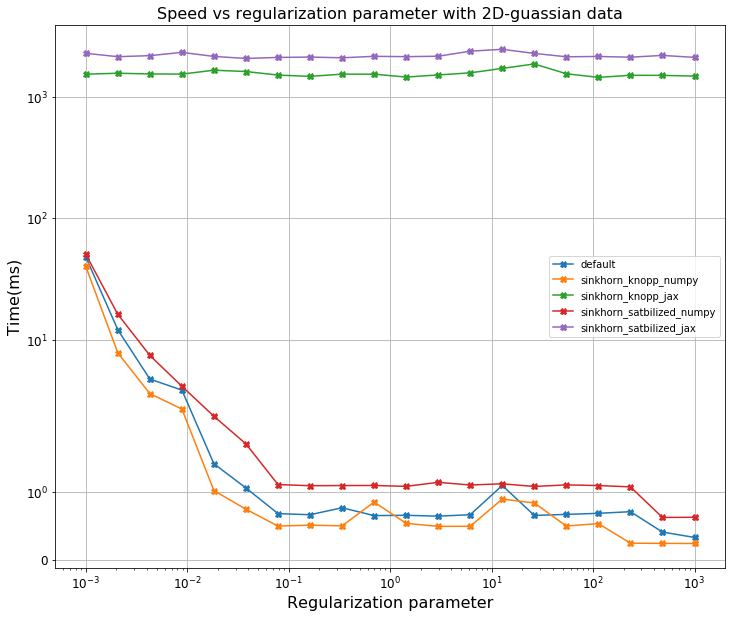

In [67]:
plt.figure(figsize=(12, 10))
plt.plot(regs,np.array(ts)*1000,marker='X',label='default')
plt.plot(regs,np.array(ts1)*1000,marker='X',label='sinkhorn_knopp_numpy')
plt.plot(regs,np.array(ts2)*1000,marker='X',label='sinkhorn_knopp_jax')
plt.plot(regs,np.array(ts3)*1000,marker='X',label='sinkhorn_satbilized_numpy')
plt.plot(regs,np.array(ts4)*1000,marker='X',label='sinkhorn_satbilized_jax')
plt.xlabel('Regularization parameter',fontsize=16)
plt.xscale('log')
plt.ylabel('Time(ms)',fontsize=16)
plt.yscale('symlog')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Speed vs regularization parameter with 2D-guassian data',fontsize=16)
plt.grid()
plt.legend()

<a id=’section_2’></a>
### Sanity check for checking that changing the regularization parameter will not affect the accuracy of the algorithm

In [68]:
'''Exp 2'''
res=np.array(res)
res1=np.array(res1)
res2=np.array(res2)
res3=np.array(res3)
res4=np.array(res4)
sums=np.zeros(20)
sums1=np.zeros(20)
sums2=np.zeros(20)
sums3=np.zeros(20)
sums4=np.zeros(20)
for i in range(20):
    sums[i]=res[i].sum()
    sums1[i]=res[i].sum()
    sums2[i]=res[i].sum()
    sums3[i]=res[i].sum()
    sums4[i]=res[i].sum()

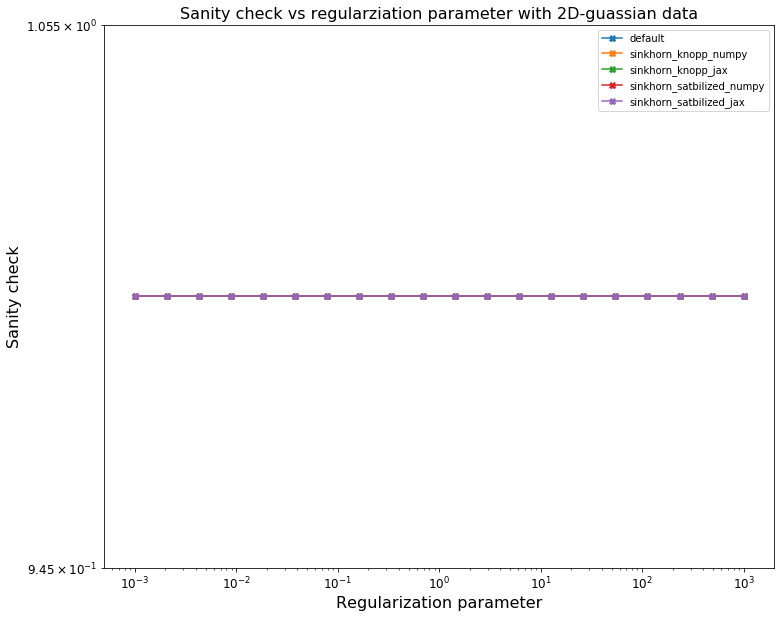

In [69]:
plt.figure(figsize=(12, 10))
plt.plot(regs,sums,marker='X',label='default')
plt.plot(regs,sums1,marker='X',label='sinkhorn_knopp_numpy')
plt.plot(regs,sums2,marker='X',label='sinkhorn_knopp_jax')
plt.plot(regs,sums3,marker='X',label='sinkhorn_satbilized_numpy')
plt.plot(regs,sums4,marker='X',label='sinkhorn_satbilized_jax')
plt.xlabel('Regularization parameter',fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Sanity check',fontsize=16)
plt.yscale('symlog')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Sanity check vs regularziation parameter with 2D-guassian data',fontsize=16)
plt.legend()

## Speed vs regularization parameter using 1D-Gaussian data

In [70]:
'''Exp 3'''
a,b,x,M =data_1d_gaus()
regs = np.logspace(-3,3,num=20)
ts=[]
ts1=[]
ts2=[]
ts3=[]
ts4=[]
res=[]
res1=[]
res2=[]
res3=[]
res4=[]
for reg in tqdm(regs):
    start=timer()
    tp=ot.sinkhorn(a, b, M, reg)
    end=timer()
    ts.append(end-start)
    res.append(tp)
    start=timer()
    tp=snk.sinkhorn_knopp(M,reg,a,b)
    end=timer()
    ts1.append(end-start)
    res1.append(tp)
    start=timer()
    tp=snk.sinkhorn_stabilized(M,reg,a,b)
    end=timer()
    ts3.append(end-start)
    res3.append(tp)
    start=timer()
    tp=snk.sinkhorn_stabilized(jax.numpy.array(M),reg,a,b)
    end=timer()
    ts4.append(end-start)
    res4.append(tp)

100%|██████████| 20/20 [00:42<00:00,  2.13s/it]


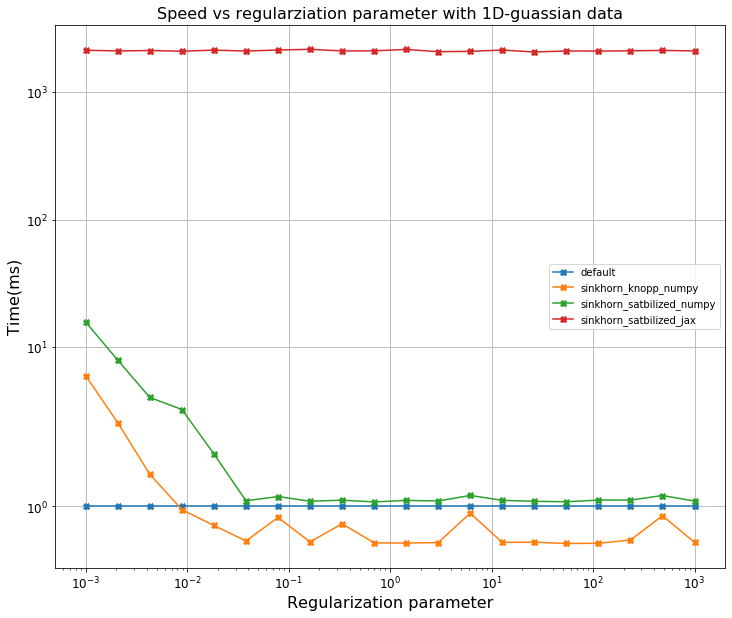

In [71]:
plt.figure(figsize=(12, 10))
plt.plot(regs,sums,marker='X',label='default')
plt.plot(regs,np.array(ts1)*1000,marker='X',label='sinkhorn_knopp_numpy')
plt.plot(regs,np.array(ts3)*1000,marker='X',label='sinkhorn_satbilized_numpy')
plt.plot(regs,np.array(ts4)*1000,marker='X',label='sinkhorn_satbilized_jax')
plt.xlabel('Regularization parameter',fontsize=16)
plt.xscale('log')
plt.yscale('symlog')
plt.ylabel('Time(ms)',fontsize=16)
plt.title('Speed vs regularziation parameter with 1D-guassian data',fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.legend()

##  Cost of transportation plan computed by the algorithm vs regularziation parameter with 2D-Guassian data

In [72]:
'''Exp 4'''
cost=np.zeros((5,20))
regs = np.logspace(-2,3,num=20)
a,b,M=data_2d_gaus(500)
i=0
for reg in tqdm(regs):
    tp=ot.sinkhorn(a, b, M, reg)
    cost[0][i]=get_cost(tp,M)
    tp=snk.sinkhorn_knopp(M,reg,a,b)
    cost[1][i]=get_cost(tp,M)
    tp=snk.sinkhorn_knopp(jax.numpy.array(M),reg,a,b)
    cost[2][i]=get_cost(tp,M)
    tp=snk.sinkhorn_stabilized(M,reg,a,b)
    cost[3][i]=get_cost(tp,M)
    tp=snk.sinkhorn_stabilized(jax.numpy.array(M),reg,a,b)
    cost[4][i]=get_cost(tp,M)
    i=i+1

100%|██████████| 20/20 [00:51<00:00,  2.59s/it]


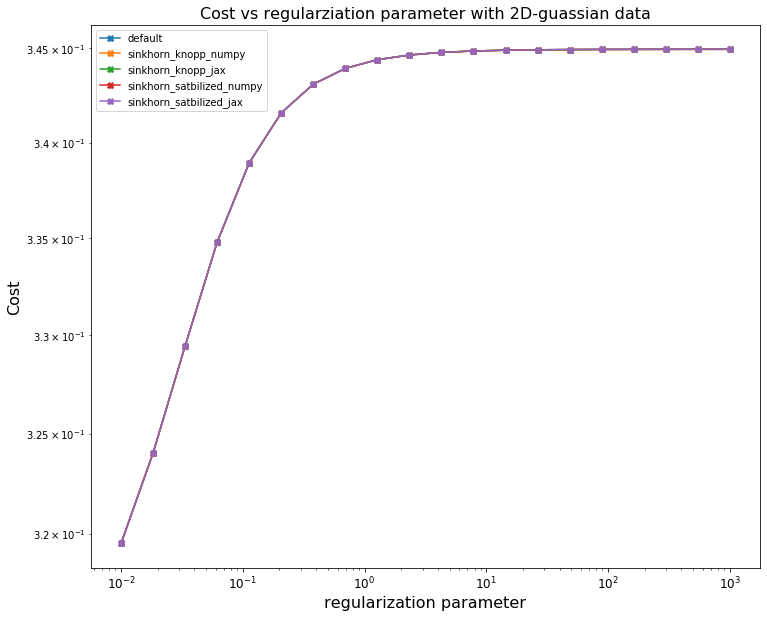

In [73]:
plt.figure(figsize=(12, 10))
plt.plot(regs,cost[0],marker='X',label='default')
plt.plot(regs,cost[1],marker='X',label='sinkhorn_knopp_numpy')
plt.plot(regs,cost[2],marker='X',label='sinkhorn_knopp_jax')
plt.plot(regs,cost[3],marker='X',label='sinkhorn_satbilized_numpy')
plt.plot(regs,cost[4],marker='X',label='sinkhorn_satbilized_jax')
plt.xlabel('regularization parameter',fontsize=16)
plt.xscale('log')
plt.ylabel('Cost',fontsize=16)
plt.yscale('log')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Cost vs regularziation parameter with 2D-guassian data',fontsize=16)
plt.legend()

## Speed vs size of 2D-guassian data using sparsification(threshold)

In [74]:
'''Exp 5'''
ts=[]
ts1=[]
ts2=[]
ts3=[]
ts4=[]
res=[]
res1=[]
res2=[]
res3=[]
res4=[]
reg=1e-1
for i in tqdm(np.arange(20,1000,50)):
    a,b,M=data_2d_gaus(i)
    start=timer()
    tp=ot.sinkhorn(a, b, M, reg)
    end=timer()
    ts.append(end-start)
    start=timer()
    tp=snk.sinkhorn_knopp(M,reg,a,b,make_sparse=True,sparsification_strategy='threshold')
    end=timer()
    ts1.append(end-start)
    start=timer()
    tp=snk.sinkhorn_stabilized(M,reg,a,b,make_sparse=True,sparsification_strategy='threshold')
    end=timer()
    ts2.append(end-start)
    start=timer()
    tp=snk.sinkhorn_knopp(M,reg,a,b,make_sparse=True,min_nnz=i,sparsification_strategy='keep_n_largest')
    end=timer()
    ts3.append(end-start)
    tp=snk.sinkhorn_stabilized(M,reg,a,b,make_sparse=True,min_nnz=i,sparsification_strategy='keep_n_largest')
    end=timer()
    ts4.append(end-start)

100%|██████████| 20/20 [00:02<00:00,  7.09it/s]


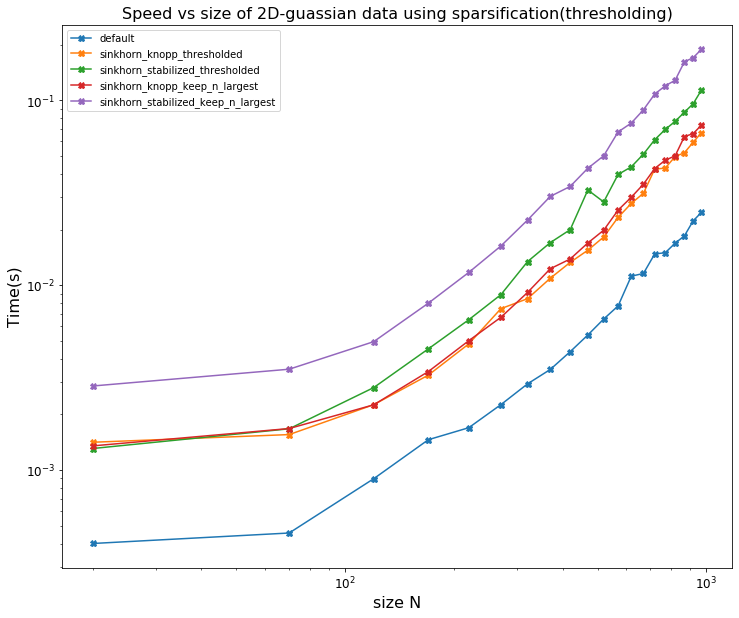

In [75]:
plt.figure(figsize=(12, 10))
plt.plot(np.arange(20,1000,50),ts,marker='X',label='default')
plt.plot(np.arange(20,1000,50),ts1,marker='X',label='sinkhorn_knopp_thresholded')
plt.plot(np.arange(20,1000,50),ts2,marker='X',label='sinkhorn_stabilized_thresholded')
plt.plot(np.arange(20,1000,50),ts3,marker='X',label='sinkhorn_knopp_keep_n_largest')
plt.plot(np.arange(20,1000,50),ts4,marker='X',label='sinkhorn_stabilized_keep_n_largest')
plt.xlabel('size N',fontsize=16)
plt.ylabel('Time(s)',fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Speed vs size of 2D-guassian data using sparsification(thresholding)',fontsize=16)
#plt.grid()
plt.legend()

## Speed vs size of 2D-guassian data using sparsification(keep_n_largest)

In [76]:
'''Exp 6'''
ts=[]
ts1=[]
ts2=[]
ts3=[]
res=[]
res1=[]
res2=[]
res3=[]
for i in tqdm(np.arange(20,1000,50)):
    a,b,M=data_2d_gaus(i)
    start=timer()
    tp=ot.sinkhorn(a, b, M, reg)
    end=timer()
    ts.append(end-start)
    res.append(tp)
    start=timer()
    tp=snk.sinkhorn_knopp(M,reg,a,b,make_sparse=True,min_nnz=i,sparsification_strategy='keep_n_largest')
    end=timer()
    ts1.append(end-start)
    res1.append(tp)
    start=timer()
    tp=snk.sinkhorn_stabilized(M,reg,a,b,make_sparse=True,min_nnz=i,sparsification_strategy='keep_n_largest')
    end=timer()
    ts2.append(end-start)
    res2.append(tp)

100%|██████████| 20/20 [00:01<00:00, 11.64it/s]


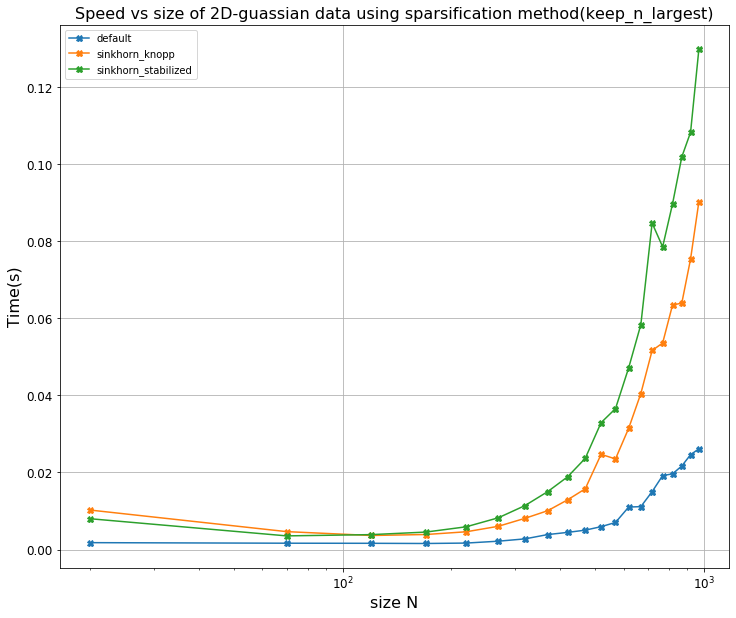

In [77]:
plt.figure(figsize=(12, 10))
plt.plot(np.arange(20,1000,50),ts,marker='X',label='default')
plt.plot(np.arange(20,1000,50),ts1,marker='X',label='sinkhorn_knopp')
plt.plot(np.arange(20,1000,50),ts2,marker='X',label='sinkhorn_stabilized')
plt.xlabel('size N',fontsize=16)
plt.xscale('log')
plt.ylabel('Time(s)',fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Speed vs size of 2D-guassian data using sparsification method(keep_n_largest)',fontsize=16)
plt.grid()
plt.legend()

##  Cost vs size of 2D-guassian data using sparsification(threshold)

In [78]:
'''Exp 7'''
cost=np.zeros((3,20))
reg=1e-1
i=0
val=np.arange(20,1000,50)
for n in tqdm(val):
    a,b,M=data_2d_gaus(n)
    tp=ot.sinkhorn(a, b, M, reg)
    tp
    cost[0][i]=get_cost(tp,M)
    tp=snk.sinkhorn_knopp(M,reg,a,b,make_sparse=True,sparsification_strategy='threshold')
    cost[1][i]=get_cost(tp,M)
    tp=snk.sinkhorn_knopp(M,reg,a,b,make_sparse=True,sparsification_strategy='threshold')
    cost[2][i]=get_cost(tp,M)
    i=i+1

100%|██████████| 20/20 [00:01<00:00, 15.21it/s]


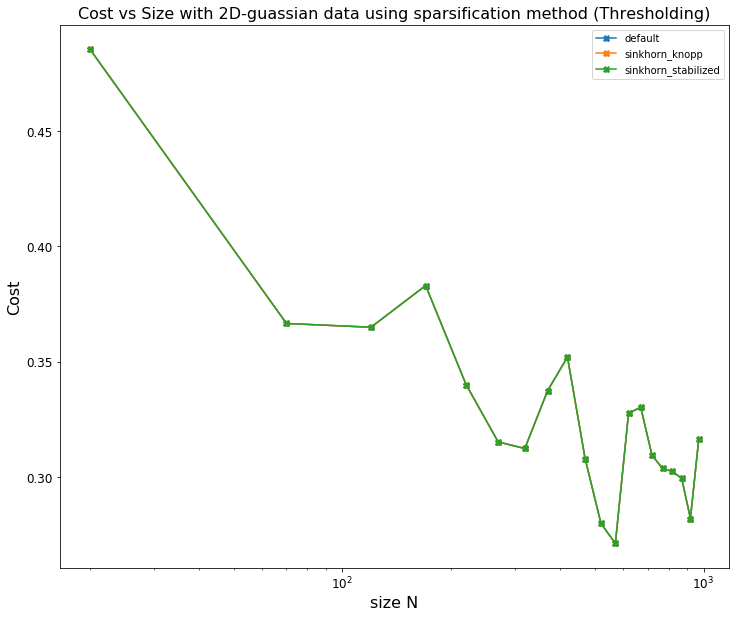

In [79]:
plt.figure(figsize=(12, 10))
plt.plot(val,cost[0],marker='X',label='default')
plt.plot(val,cost[1],marker='X',label='sinkhorn_knopp')
plt.plot(val,cost[2],marker='X',label='sinkhorn_stabilized')
plt.xlabel('size N',fontsize=16)
plt.xscale('log')
plt.ylabel('Cost',fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Cost vs Size with 2D-guassian data using sparsification method (Thresholding)',fontsize=16)
plt.legend()

##  Cost vs size of 2D-guassian data using sparsification(keep_n_largest)

In [80]:
'''Exp 8'''
cost=np.zeros((5,20))
reg=1e-1
i=0
for n in tqdm(np.arange(20,1000,50)):
    a,b,M=data_2d_gaus(n)
    tp=ot.sinkhorn(a, b, M, reg)
    cost[0][i]=get_cost(tp,M)
    tp=snk.sinkhorn_knopp(M,reg,a,b,make_sparse=True,min_nnz=n,sparsification_strategy='keep_n_largest')
    cost[1][i]=get_cost(tp,M)
    tp=snk.sinkhorn_knopp(M,reg,a,b,make_sparse=True,min_nnz=n,sparsification_strategy='keep_n_largest')
    cost[2][i]=get_cost(tp,M)
    i=i+1

100%|██████████| 20/20 [00:01<00:00, 12.56it/s]


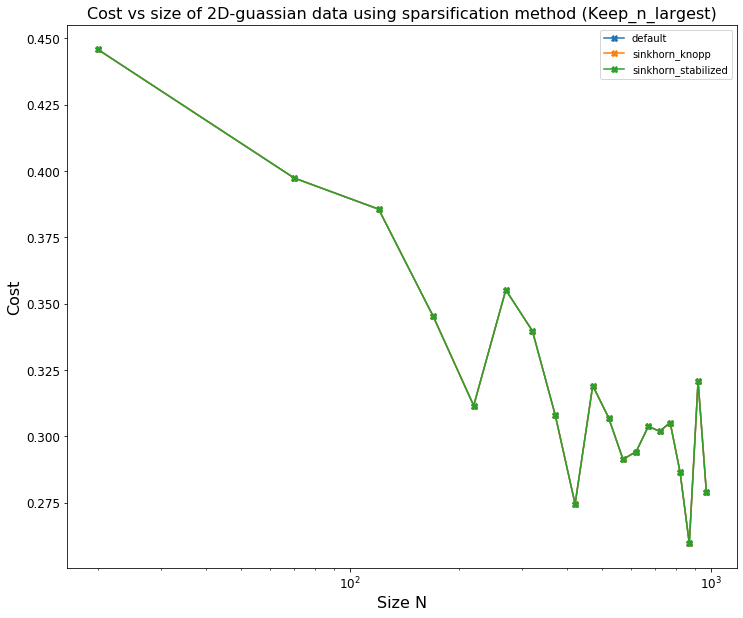

In [81]:
plt.figure(figsize=(12, 10))
plt.plot(val,cost[0],marker='X',label='default')
plt.plot(val,cost[1],marker='X',label='sinkhorn_knopp')
plt.plot(val,cost[2],marker='X',label='sinkhorn_stabilized')
plt.xlabel('Size N',fontsize=16)
plt.xscale('log')
plt.ylabel('Cost',fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Cost vs size of 2D-guassian data using sparsification method (Keep_n_largest)',fontsize=16)
plt.legend()